In [61]:
# Ensure you have the following installed:
# numpy
# os
# compas
# compas_fd
# warnings
# traceback
# pickle

# Install by running:
# !pip install -r requirements.txt

In [62]:
import numpy as np
import pickle
import pandas as pd

# G-code generation codes are cloned from https://github.com/tibor-barsi/GcodeGenerator. Tibor Barsi is the author of the code, and was a PhD student at the Ladisk lab of the University of Ljubljana
#  We should be careful with crediting the author of the code, if we ever want to make these code public.
from src.g_code_generation_copy.gcode_generator import G_code_generator
from src.g_code_generation_copy.tool_changer_functions import save_params, load_params, printer_start, load_tool, unload_tool, tool_change, take_photo, play_sound, printer_stop
# from src.additional_functions import *
from src.network import Network_custom, replace_brackets
import os

BYU_UW_root = r"G:\.shortcut-targets-by-id\1k1B8zPb3T8H7y6x0irFZnzzmfQPHMRPx\Illimited Lab Projects\Research Projects\Spiders\BYU-UW"

### Step 1: Define the network

In [63]:
# Note that the coordinates of the vertices will change after equilibrium is reached.
vertices    = np.array([[-10, 0, 0], [-5, 0,0], [5, 0, 0], [10, 0, 0], [0,-10,0], [0,-5,0], [0,5,0], [0,10,0]])*11  # The coordinates of the vertices in mm
edges       = [[0, 1], [1, 5], [5, 2], [2, 3], [4, 5], [5, 6], [6,7], [1, 6], [6, 2]]                  # The edges of the network.
paths       = [[0, 1, 2, 3], [4, 5, 6], [7, 8]]   # 3D printable paths. Ensure an edge is not flipped.
directions  = [1, 1, 1, 1, 1, 1, 1, 1, 1]          # Flip the curvature of an edge by setting the direction to -1.

scalar = 110
q_ring      = .5
q_connectors = .8
q_center    = .2
q           = np.array([q_connectors, q_ring, q_ring, q_connectors, q_connectors, q_center, q_connectors, q_ring, q_ring])/scalar
# q[2]        = 1.5/scalar
# q[-1]        = 1.5/scalar
fixed       = [0, 3, 4, 7]
# model_name  = 'VS_ring{}_connectors{}_center{}_as{}'.format(q_ring, q_connectors, q_center, q[2]*scalar)
# model_name  = 'VS_ring{}_connectors{}_center{}_as{}_asr{}_s{}'.format(q_ring, q_connectors, q_center, q[2]*scalar, q[-1]*scalar, scalar)
model_name  = 'unit_cell'

# Create the network
net = Network_custom.from_fd(vertices, edges, q, fixed, paths = paths, dir = directions)

# The topology of structure is fixed after generation, but you can update force densities after making the network
# q[0] = .10
# net.update_shape(q)

# Plot the network like this
net.net_plot(color=True, elables = True, vlabels = False)

(net.vertices == vertices).all() # Please understand that this is False
np.max(net.f)/0.078294515

# import matplotlib.pyplot as plt
# cmap = plt.get_cmap('viridis')

# Convert to TikZ RGB format
# f_plot = (net.f - np.min(net.f)) / (np.max(net.f) - np.min(net.f))
# for val in f_plot:
#     r, g, b, _ = cmap(val)  # Get RGBA (ignore A)color={rgb,1:red,0.282;green,0.141;blue,0.458}
#     print("\draw[thick, color = {" + f"rgb,1:red,{r:.3f}; green,{g:.3f};blue, {b:.3f}"+"}]")

np.max(net.f)/0.078294515

6.502255095275947

In [64]:
def R(theta):
    """
    Rotation matrix around the z-axis
    :param theta: angle in radians
    :return: rotation matrix
    """
    return np.array([[np.cos(theta), -np.sin(theta), 0],
                     [np.sin(theta), np.cos(theta), 0],
                     [0, 0, 1]])

# Note that the coordinates of the vertices will change after equilibrium is reached.
vertices    = np.array([[-10, 0, 0], [-5, 0,0], [0, 0, 0], [5, 0, 0], [10, 0, 0], [0,-10,0], [0,-5,0], [0,5,0], [0,10,0]])*11  # The coordinates of the vertices in mm
vertices    = vertices@R(np.pi/4)
edges       = [[0, 1], [1, 2], [2, 3], [3, 4], [5, 6], [6, 2], [2, 7], [7, 8], [1, 6], [6, 3], [3, 7], [7,1]]                  # The edges of the network.
paths       = [[0, 1, 2, 3], [4, 5, 6, 7], [8, 9, 10, 11]]   # 3D printable paths. Ensure an edge is not flipped.
directions  = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]          # Flip the curvature of an edge by setting the direction to -1.
center_cross_path = [1, 2, 5, 6]
connector_path = [0, 3, 4, 7]
q_scalar = 1.3
sum_q0 = 0.02*q_scalar
sum_q1 = 0.02*q_scalar
sum_q2 = 0.01*q_scalar
offset = 1/64
ratio_0 = np.array([3/8-offset, 1/8, 1/8, 3/8+offset])
ratio_1 = np.array([3/8, 1/8-offset, 1/8+offset, 3/8])
ratio_2 = np.array([2/8-offset, 2/8+offset, 2/8, 2/8])

q = np.zeros(len(edges))
q[paths[0]] = sum_q0*ratio_0
q[paths[1]] = sum_q1*ratio_1
q[paths[2]] = sum_q2*ratio_2

fixed       = [0, 4, 5, 8]
# Create the network
net = Network_custom.from_fd(vertices, edges, q, fixed, paths = paths, dir = directions)
net.net_plot(color=True, elables = True, vlabels = False)
np.max(net.f)/0.078294515
vertices

array([[-77.78174593,  77.78174593,   0.        ],
       [-37.33234462,  38.80929805,   0.        ],
       [  3.22839326,   1.65811444,   0.        ],
       [ 39.58655044, -39.78515241,   0.        ],
       [ 77.78174593, -77.78174593,   0.        ],
       [-77.78174593, -77.78174593,   0.        ],
       [-38.03553309, -40.47359918,   0.        ],
       [ 39.05818547,  38.24241015,   0.        ],
       [ 77.78174593,  77.78174593,   0.        ]])

In [65]:
file_path = os.path.join(BYU_UW_root, 'Avg_Stress_Strain_Overture_TPU.csv')
stress_data, strain_data = net.load_stress_strain_curve(file_path)
TPU_nl = {'stress':strain_data, 'strain': stress_data, 'v':0.3897, 'p':1.18e-9, 'A': 0.078294515, 'name': 'TPU Overture'} # TPU Overture non-conductive
A = [TPU_nl['A']]*len(net.edges)
l0, l_scalar = net.materialize_nonlinear(A, stress_data, strain_data, interpolation_kind = 'cubic')
strain_to_stress = net.material_model(stress_data, strain_data, interpolation_kind = 'cubic')

In [ ]:
# vertices = net.vertices.copy()*1.1
vertices_equilibrium, l1, f = net.find_equilibrium(vertices, A, strain_to_stress)
# net.net_plot(color=False, elables = True, vlabels = False, custom_vertices = vertices_equilibrium)
# f/A

Constant settings

In [67]:
printing_params = load_params(r'DATA/NT_Eel_0.2mm_og.json')
alpha_loop = np.deg2rad(30) # The angle of the loop
L_loop  = 5                # The length of the loop
n_points = 60               # The number of points in the loop

start_gcode     = open(r'DATA/start_gcode.gcode', 'r').read()
end_gcode       = open(r'DATA/end_gcode.gcode', 'r').read()

temperature_settings = {'first_layer_bed_temperature': 65, 'first_layer_temperature':205, 'K-factor': 0.20}
comment = ''

bed_width = 230
bed_height = 210

start_loop_bools = [True, True, False]
end_loop_bools = [True, True, False]
file_path = os.path.join(BYU_UW_root, 'Avg_Stress_Strain_Overture_TPU.csv')
stress_data, strain_data = net.load_stress_strain_curve(file_path)

TPU_nl = {'stress':strain_data, 'strain': stress_data, 'v':0.3897, 'p':1.18e-9, 'A': 0.078294515, 'name': 'TPU Overture'} # TPU Overture non-conductive

A = [TPU_nl['A']]*len(net.edges)

# Purge line coors
gen = G_code_generator(printing_params)
point0, point1 = [20,15,0.3], [90,15,0.3]
point2, point3 = [90,10,0.3], [20,10,0.3]

def make_purge_line(g_code, printing_params, gen, point0, point1, comment=''):
    """"
    ""Make a purge line at the start of the print."
    """
    g_code += gen.move_to_point(point0[0:2], point0[2] + printing_params['nozzle_lift'], comment='Move to start point')
    g_code += gen.move_to_point(point0[0:2], point0[2], comment='Lower Nozzle')
    g_code += gen.unretract()
    g_code += gen._print_line(
            point0=point0,
            point1=point1,
            move_to_start=False, # move to start point without extruding
            extrude_factor=printing_params['extrude_factor']*2.5,
            comment=comment)
    g_code += gen.retract()
    g_code += gen.wipe(2 * np.pi)
    return g_code

def add_net_to_gcode(g_code, printing_params, gen, net):
    for path_i, cor_list in enumerate(net.paths_xyz):
        g_code += '\n;Path (' + str(path_i) + ' ' + str(path_i) + ')\n'
        cor_list   = np.array(cor_list)
        # Move the coordinates to the center of the bed and add the layer height
        cor_list[:,0] += bed_width/2 -14
        cor_list[:,1] += bed_height/2 
        cor_list[:,2] += printing_params['layer_height']
        g_code += '\n'
        # Move the coordinates to the start point
        g_code += gen.move_to_point(cor_list[0][0:2], cor_list[0][2] + printing_params['nozzle_lift'], comment='Move to start point')
        # Lower the nozzle
        g_code += gen.move_to_point(cor_list[0][0:2], cor_list[0][2], comment='Lower Nozzle')
        # Unretract the filament
        g_code += gen.unretract()
        # Print the path
        for point0, point1 in zip(cor_list[:-1], cor_list[1:]):
                g_code += gen._print_line(
                point0=point0,
                point1=point1,
                move_to_start=False, # move to start point without extruding
                extrude_factor = printing_params['extrude_factor'],
                comment=comment)
        # Retract the filament
        g_code += gen.retract()
        # Wipe the nozzle
        g_code += gen.wipe_from_last_points(g_code)    
        # Raise the nozzle
        g_code += gen.move_to_point(point1[0:2], point1[2] + printing_params['nozzle_lift'], speed_factor=0.5, comment='Raise Nozzle')
    return g_code

Generate 4 specimens only changing the tension

In [68]:
q0 = q.copy()
q_scalars = [0.35, 0.6, 1.0, 1.1]
for q_scalar in q_scalars:
    q_new = q0*q_scalar
    net.update_shape(q_new)
    l0, l_scalar = net.materialize_nonlinear(A, stress_data, strain_data, interpolation_kind = 'cubic')
    net.initialize_shape_optimizer(function_type = 'standard',  method = 'Gauss-Seidel',options ={"maxiter": 1000, "damping": .1, "correction_scalar": 1.5, "tol": 1e-6})
    net.optimize_vertices()
    reference_point = [0,0,0]                         # The network will be scaler relative to this point
    net.scale_vertices(reference_point, net.l_scalar, account_for_leafs = True) # If you don't provide a scalar, it will use network.l_scalar automatically
    R, th = net.arc_param()
    xyz = net.arc_points(n = 10)
    net.auto_flip_curves(n = 10)        # Automatically flip the curvature of the edges. Directions will become 1, -1, 1, -1, ...
    net.flip_curves()                   # Flip all the edges.
    net.flip_curves([2, 5, 8], n = 10)
    net.jump_at_intersection(intersection_width = printing_params['d_nozzle']*1.5, intersection_height = printing_params['layer_height'], interpolation_function=None) 
    net.net_plot(color=True, plot_type='arcs', elables=True, vlabels = True)
    net.all_loop_to_path(start_loop_bools, end_loop_bools, L_loop, alpha_loop, n_points)
    net.save_network(os.path.join(BYU_UW_root, 'networks', model_name + f'_even_q_{q_scalar}.pkl'))
    print(f"q_scalar: {q_scalar}, l_scalar: {l_scalar}, max stress: {np.max(net.f)/TPU_nl['A']}")

    g_code = replace_brackets(start_gcode, temperature_settings)
    g_code += make_purge_line(g_code, printing_params, gen, point0, point1, comment='Purge line')
    g_code += make_purge_line(g_code, printing_params, gen, point2, point3, comment='Purge line')
    g_code += add_net_to_gcode(g_code, printing_params, gen, net)

    g_code += end_gcode
    with open(os.path.join('DATA', 'generated_gcodes', model_name + f'_even_q_{q_scalar}.gcode'), "w") as g_code_file:
        g_code_file.write(g_code)
    

Iteration 0: Current error = 9.772632123710627
Iteration 100: Current error = 0.10201245842409892
Iteration 200: Current error = 0.09366358463771193
Iteration 300: Current error = 0.09331641130239138
Converged after 327 iterations.
Final error: 0.09379495646014685


q_scalar: 0.35, l_scalar: 0.9743394583944192, max stress: 2.446046661023549
Iteration 0: Current error = 42.31887101741464
Iteration 100: Current error = 0.39211488399204797
Iteration 200: Current error = 0.3567850727364139
Iteration 300: Current error = 0.3546044822408199
Iteration 400: Current error = 0.3577197233535002
Iteration 500: Current error = 0.35506247067545843
Iteration 600: Current error = 0.3560580197272298
Iteration 700: Current error = 0.3553334546135922
Iteration 800: Current error = 0.35777156325956855
Iteration 900: Current error = 0.3579091868867941
Final error: 0.35588650780842557


q_scalar: 0.6, l_scalar: 0.9441168173077795, max stress: 4.193222847468942
Iteration 0: Current error = 243.87130038728026
Iteration 100: Current error = 1.8448076145533707
Iteration 200: Current error = 1.6775586871709767
Iteration 300: Current error = 1.6729376563894738
Iteration 400: Current error = 1.6683100667892796
Iteration 500: Current error = 1.6712988086953744
Iteration 600: Current error = 1.672156925946209
Iteration 700: Current error = 1.6812526480875642
Iteration 800: Current error = 1.6889040109704372
Iteration 900: Current error = 1.673653285957224
Final error: 1.6811150158562416


q_scalar: 1.0, l_scalar: 0.855151246107656, max stress: 6.988704745781568
Iteration 0: Current error = 361.7307265964698
Iteration 100: Current error = 2.566773105927049
Iteration 200: Current error = 2.354738186598261
Iteration 300: Current error = 2.332801458252311
Iteration 400: Current error = 2.3400800324330038
Iteration 500: Current error = 2.3556567435651896
Iteration 600: Current error = 2.3269683273916075
Iteration 700: Current error = 2.3502473054691735
Iteration 800: Current error = 2.339494113476125
Iteration 900: Current error = 2.3422311014479145
Final error: 2.337028927553863


q_scalar: 1.1, l_scalar: 0.819545949423485, max stress: 7.687575220359728


Generate specimens making inner part iteratively smaller

In [80]:
q0 = q.copy()
q_scalars_connector = [.8, .6, .4, .35]
q_scalars_ring = [ 1.5, 4, 6, 13]
q_scalars_cross = [2, 3, 5, 14]
for q_scalar_ring, q_scalar_cross, q_scalar_connector in zip(q_scalars_ring, q_scalars_cross, q_scalars_connector):
    q_new = q.copy()
    q_new[paths[2]]*= q_scalar_ring
    q_new[center_cross_path] *= q_scalar_cross
    q_new[connector_path] *= q_scalar_connector
    net.update_shape(q_new)
    l0, l_scalar = net.materialize_nonlinear(A, stress_data, strain_data, interpolation_kind = 'cubic')
    net.initialize_shape_optimizer(function_type = 'standard',  method = 'Gauss-Seidel',options ={"maxiter": 1000, "damping": .1, "correction_scalar": 1.5, "tol": 1e-6})
    net.optimize_vertices()
    reference_point = [0,0,0]                         # The network will be scaler relative to this point
    net.scale_vertices(reference_point, net.l_scalar, account_for_leafs = True) # If you don't provide a scalar, it will use network.l_scalar automatically
    R, th = net.arc_param()
    xyz = net.arc_points(n = 10)
    net.auto_flip_curves(n = 10)        # Automatically flip the curvature of the edges. Directions will become 1, -1, 1, -1, ...
    net.flip_curves()                   # Flip all the edges.
    net.flip_curves([2, 5, 8], n = 10)
    net.jump_at_intersection(intersection_width = printing_params['d_nozzle']*1.5, intersection_height = printing_params['layer_height'], interpolation_function=None) 
    net.net_plot(color=True, plot_type='arcs', elables=True, vlabels = True)
    net.all_loop_to_path(start_loop_bools, end_loop_bools, L_loop, alpha_loop, n_points)
    net.save_network(os.path.join(BYU_UW_root, 'networks', model_name + f'_loop_size_q_{q_scalar_ring, q_scalar_cross, q_scalar_connector}.pkl'))
    print(f"l_scalar: {l_scalar}, max stress: {np.max(net.f)/TPU_nl['A']}")

    g_code = replace_brackets(start_gcode, temperature_settings)
    g_code += make_purge_line(g_code, printing_params, gen, point0, point1, comment='Purge line')
    g_code += make_purge_line(g_code, printing_params, gen, point2, point3, comment='Purge line')
    g_code += add_net_to_gcode(g_code, printing_params, gen, net)

    g_code += end_gcode
    with open(os.path.join('DATA', 'generated_gcodes', model_name + f'_loop_size_q_{q_scalar_ring, q_scalar_cross, q_scalar_connector}.gcode'), "w") as g_code_file:
        g_code_file.write(g_code)

Iteration 0: Current error = 518.9673677576009
Iteration 100: Current error = 0.2592064004108588
Iteration 200: Current error = 0.03311929374292738
Converged after 251 iterations.
Final error: 0.03284340672462335


l_scalar: 0.8276191236216445, max stress: 7.550804614575385
Iteration 0: Current error = 639.6171521133917
Iteration 100: Current error = 0.6941329975969883
Iteration 200: Current error = 0.4425428936764285
Iteration 300: Current error = 0.4423208446467706
Iteration 400: Current error = 0.44371957840479537
Iteration 500: Current error = 0.441287400377389
Iteration 600: Current error = 0.44094638952688514
Iteration 700: Current error = 0.44175969215554
Iteration 800: Current error = 0.4391006979824658
Converged after 800 iterations.
Final error: 0.4391006979824658


l_scalar: 0.845181197131859, max stress: 7.205982721276014
Iteration 0: Current error = 212.72245552701546
Iteration 100: Current error = 0.10670760923392335
Iteration 200: Current error = 0.025318110299574408
Iteration 300: Current error = 0.025143569161806923
Converged after 324 iterations.
Final error: 0.025230618770351463


l_scalar: 0.9187513072777099, max stress: 5.2206878430122785
Iteration 0: Current error = 167.41298048550257
Iteration 100: Current error = 0.05614612493810576
Iteration 200: Current error = 0.0009070783602665063
Converged after 216 iterations.
Final error: 0.000876058595039811


l_scalar: 0.9308560046095378, max stress: 4.765086134736203


Build figures:

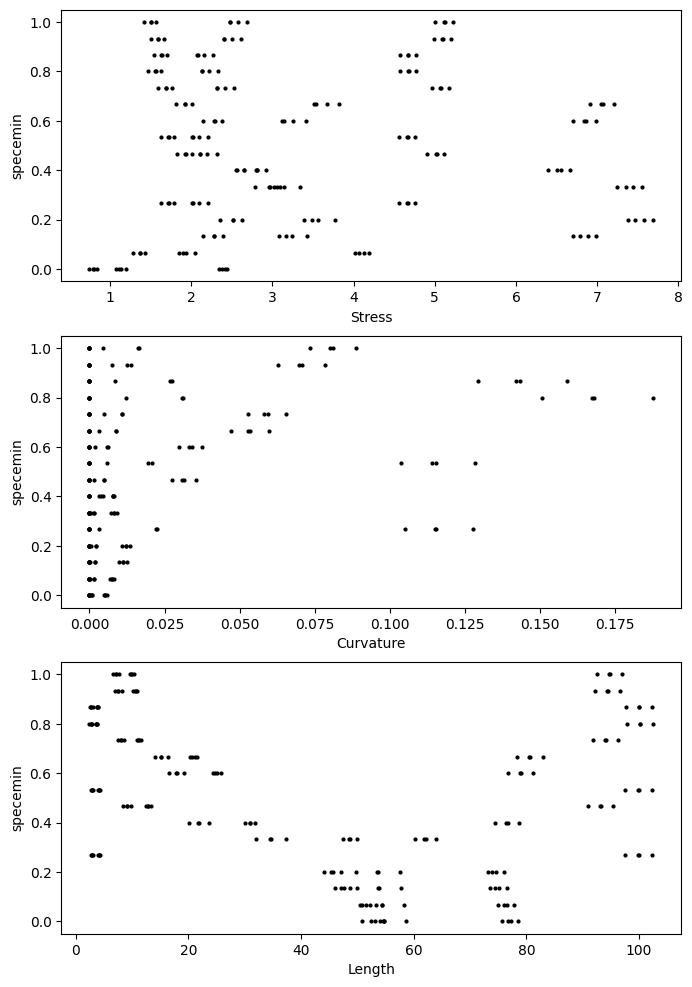

In [81]:
import matplotlib.pyplot as plt
net_path = os.path.join(BYU_UW_root, 'networks')
net_files = os.listdir(net_path)
filtered_files = [file for file in net_files if file.startswith(model_name)]

temp_error_all = np.linspace(0, 1, len(filtered_files))

ystring = 'specemin'

fig, ax = plt.subplots(3,1, figsize=(8, 12))
ax[0].set_xlabel('Stress')
ax[0].set_ylabel(ystring)
ax[1].set_xlabel('Curvature')
ax[1].set_ylabel(ystring)
ax[2].set_xlabel('Length')
ax[2].set_ylabel(ystring)

for net_file, temp_error in zip(filtered_files, temp_error_all):
    with open(os.path.join(net_path, net_file), 'rb') as f:
        net = pickle.load(f)
    for edge, fi, l0i, Ri in zip(net.edges, net.f, net.l0, net.R):
        kappai = 1/Ri
        ax[0].plot(fi/TPU_nl['A'], temp_error, 'o', color='black', markersize=2)
        ax[1].plot(kappai, temp_error, 'o', color='black', markersize=2)
        ax[2].plot(l0i, temp_error, 'o', color='black', markersize=2)

In [71]:
# for edge_i, edge in enumerate(net.edges): (-3.13, 0.987) arc (239.60: 277.368:8.4696);
#     v0, v1 = edge
#     coor0, coor1 = net.vertices[v0], net.vertices[v1]
#     print(f'{edge_i}, starts at {coor0}, ends at {coor1}, and has a radius of {net.R[edge_i]} and an angle of {net.th[edge_i]}')
for edge_i, edge in enumerate(net.edges):
    v0, v1 = edge
    coor0, coor1 = net.vertices[v0], net.vertices[v1]
    R, th = net.R[edge_i], net.th[edge_i]
    center, theta0, theta1 = net._points_on_arc(coor0[:2], coor1[:2], R, print_parameters = True)
    # print(coor0[:2]/10, theta0*180/np.pi, theta1*180/np.pi, R)
    if R/10 > 10000:
        print(f"\draw ({coor0[0]/10:.3f}, {coor0[1]/10:.3f}) -- ({coor1[0]/10:.3f}, {coor1[1]/10:.3f});")
        continue
    if theta0 > theta1:
        print(f"\draw ({coor1[0]/10:.3f}, {coor1[1]/10:.3f}) arc ({theta0*180/np.pi:.3f}:{theta1*180/np.pi:.3f}:{-R/10:.3f});")
    else:
        print(f"\draw ({coor0[0]/10:.3f}, {coor0[1]/10:.3f}) arc ({theta0*180/np.pi:.3f}:{theta1*180/np.pi:.3f}:{R/10:.3f});")

\draw (-7.778, 7.778) -- (-0.034, 0.048);
\draw (-0.034, 0.048) arc (215.146:238.179:0.704);
\draw (0.170, -0.145) arc (209.326:232.697:0.697);
\draw (0.355, -0.358) -- (7.778, -7.778);
\draw (-7.778, -7.778) -- (-0.040, -0.364);
\draw (-0.040, -0.364) arc (304.882:327.348:0.780);
\draw (0.170, -0.145) arc (304.068:328.236:0.623);
\draw (0.351, 0.043) -- (7.778, 7.778);
\draw (-0.034, 0.048) arc (176.047:182.210:3.831);
\draw (-0.040, -0.364) arc (267.878:273.857:3.796);
\draw (0.355, -0.358) arc (359.187:362.071:7.972);
\draw (0.351, 0.043) -- (-0.034, 0.048);


<>:12: SyntaxWarning:

invalid escape sequence '\d'

<>:15: SyntaxWarning:

invalid escape sequence '\d'

<>:17: SyntaxWarning:

invalid escape sequence '\d'

<>:12: SyntaxWarning:

invalid escape sequence '\d'

<>:15: SyntaxWarning:

invalid escape sequence '\d'

<>:17: SyntaxWarning:

invalid escape sequence '\d'

C:\Users\thijs\AppData\Local\Temp\ipykernel_17804\621585458.py:12: SyntaxWarning:

invalid escape sequence '\d'

C:\Users\thijs\AppData\Local\Temp\ipykernel_17804\621585458.py:15: SyntaxWarning:

invalid escape sequence '\d'

C:\Users\thijs\AppData\Local\Temp\ipykernel_17804\621585458.py:17: SyntaxWarning:

invalid escape sequence '\d'



Make the paths

In [72]:
minx, miny = 90, 90
maxx, maxy = 0, 0
for path_i, cor_list in enumerate(net.paths_xyz):
    cor_list   = np.array(cor_list)
    cor_list[:,0] += bed_width/2 -14
    cor_list[:,1] += bed_height/2 
    minx = min(minx, np.min(cor_list[:,0]))
    miny = min(miny, np.min(cor_list[:,1]))
    maxx = max(maxx, np.max(cor_list[:,0]))
    maxy = max(maxy, np.max(cor_list[:,1]))

minx , miny , maxx , maxy 

(23.440900592640475, 27.505430651647288, 178.48737055607222, 182.5620892668117)